# Part 1 - Exploratory Data Analysis

Here is the task for Part 1:
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

## Data wrangling

### Importing the appropriate libraries and then reading in the file

In [1]:
import pandas as pd
import datetime as dt
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df_logins = pd.read_json(r'logins.json') # read in the file that has been provided in JSON format

### Quick cleanup as the login_times are not all in date order and that makes it a bit more difficult to handle

In [3]:
df_logins.sort_values(by='login_time',inplace=True) # sort the files to make processing easier

In [4]:
df_logins.reset_index(drop=True,inplace=True)

### Quick look at the data to see what we have

In [5]:
df_logins.head()

,login_time
0,1970-01-01 20:12:16
1,1970-01-01 20:13:18
2,1970-01-01 20:16:10
3,1970-01-01 20:16:36
4,1970-01-01 20:16:37


In [6]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [7]:
df_logins.describe()

,login_time
count,93142
unique,92265
top,1970-04-04 01:17:40
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


### I found it easiest to create a new dataframe with the 15 minute increments built into the rows.  

In [8]:
# setup a new dataframe to hold the data in 15 minute increments
columns = ['block_date','login_count']
df_blocks = pd.DataFrame(columns=columns)

### Building out the new dataframe, df_blocks, to have the 15 mintue time increments in the first column

In [9]:
# quick loop to populate the block dates in 15 minute increments
start = dt.datetime(1970,1,1,20,0,0) # this is just before the earliest login
end = max(df_logins.login_time) # the last login provided
step = dt.timedelta(minutes=15) # we want steps in 15 minute increments
count = (end - start)/step # this is exactly how many steps we will need with decimal places
steps = int(math.ceil(count)) # this essentially rounds the steps up to the next whole number
k=0

for i in range(0,steps+1):
    df_blocks = df_blocks.append({'block_date': start}, ignore_index=True) # add a new row with the next time block
    start = start + step

In [10]:
df_blocks.head()

,block_date,login_count
0,1970-01-01 20:00:00,NaT
1,1970-01-01 20:15:00,NaT
2,1970-01-01 20:30:00,NaT
3,1970-01-01 20:45:00,NaT
4,1970-01-01 21:00:00,NaT


### For every row on our new dataframe, df_blocks, we will see how many rows on the logins dataframe fit and add that number to the login_count column

In [11]:
j = 0 # this will be our iterator for the df_logins DataFrame

for i in df_blocks.index: # iterating through each block date in df_blocks
    count = 0 # the number of times that a login time happened for each time block
    df_blocks.iloc[i,1] = count
    searching = True # this will keep us in the while loop to iterate over the login times
    while searching == True:
        if j > (len(df_logins.index)-1): # if we have reached the end of the df_logins table 
            df_blocks.iloc[i,1] = count
            searching = False
        else:
            if (df_logins.iloc[j,0] >= df_blocks.iloc[i,0] and df_logins.iloc[j,0] < df_blocks.iloc[i+1,0]):
                count += 1
                df_blocks.iloc[i,1] = count
                j += 1
            else:
                searching = False

In [12]:
df_blocks.tail()

,block_date,login_count
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7
9787,1970-04-13 18:45:00,6
9788,1970-04-13 19:00:00,0


## Data Analysis

### Starting with some basic statistics, it looks like the average number of logins for 15 minutes is about 9.5

In [13]:
print("Overall average = ",df_blocks.login_count.mean())
print("Overall mean    = ",df_blocks.login_count.median())
print("Overall std dev = ",df_blocks.login_count.std())

Overall average =  9.514965777913986
Overall mean    =  7.0
Overall std dev =  8.32894825208163


### Taking a look at all the data in a line graph, there does seem to be some trends but it is hard to pull out with this look.  Breaking it down to a smaller slice starts to reveal some trends.  We can explore that a bit further.  

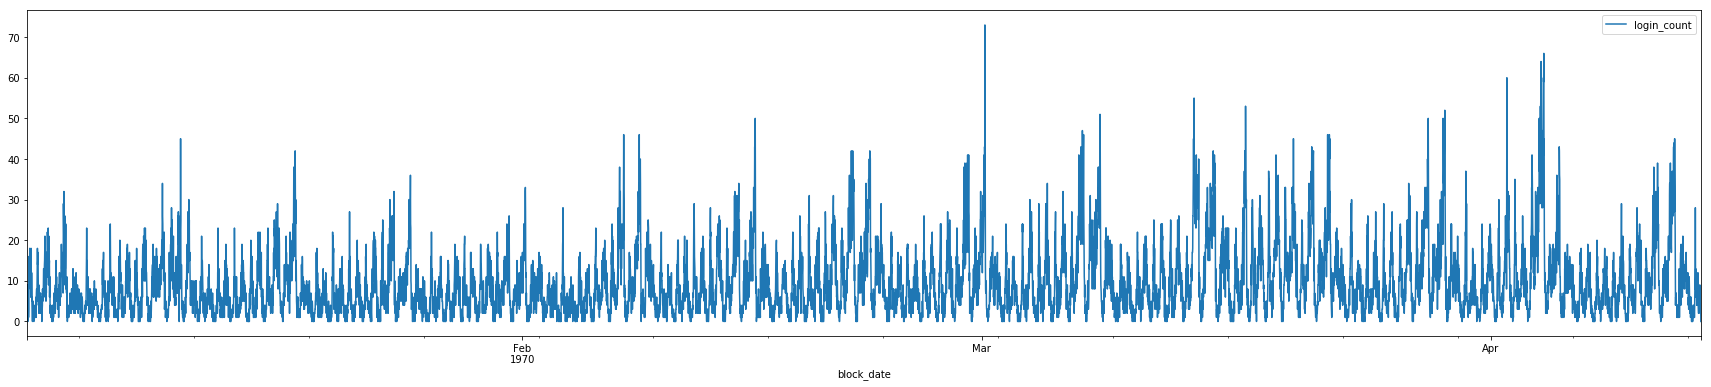

In [14]:
plt.rcParams["figure.figsize"] = (30,6) # sets the figure size for all following figures
df_blocks.plot(x='block_date',y='login_count')

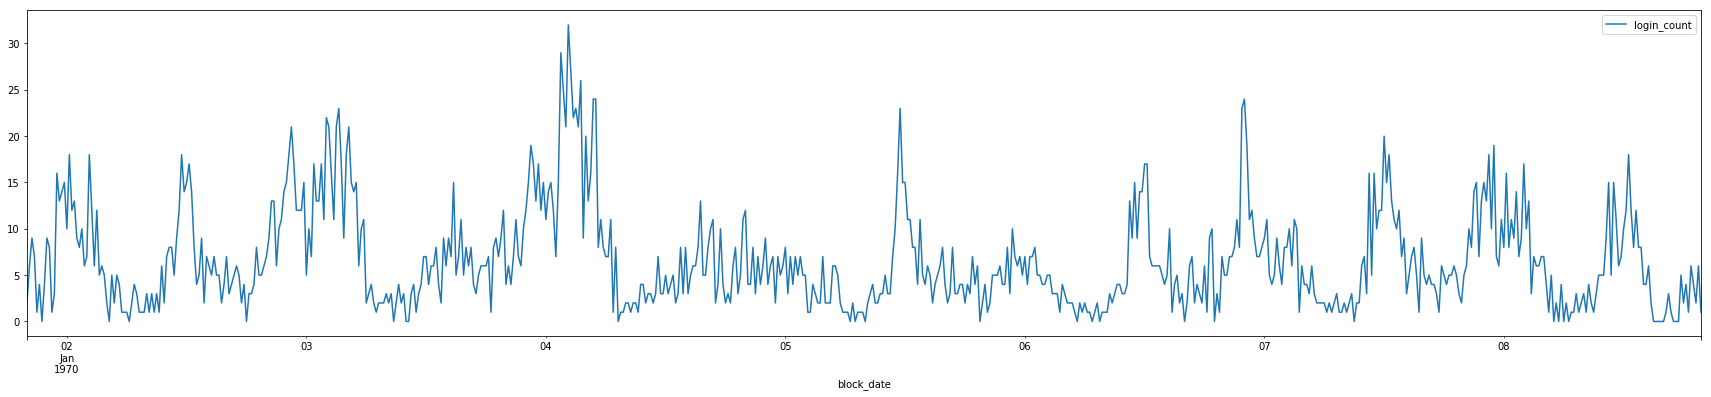

In [15]:
df_blocks.iloc[0:24*4*7].plot(x='block_date',y='login_count') #looking at just the first 100 time blocks

### We are expanding our dataframe to include columns for the month, day of the month, weekday, and hour of day

In [16]:
# Add columns with month, day, weekday name, and hour
df_blocks['login_month'] = df_blocks.block_date.dt.month
df_blocks['login_day'] = df_blocks.block_date.dt.day
df_blocks['login_weekday'] = df_blocks.block_date.dt.weekday_name
df_blocks['login_hour'] = df_blocks.block_date.dt.hour
# Display a random sampling of 5 rows
df_blocks.sample(5, random_state=0)

,block_date,login_count,login_month,login_day,login_weekday,login_hour
4399,1970-02-16 15:45:00,5,2,16,Monday,15
6358,1970-03-09 01:30:00,7,3,9,Monday,1
9269,1970-04-08 09:15:00,6,4,8,Wednesday,9
449,1970-01-06 12:15:00,17,1,6,Tuesday,12
7039,1970-03-16 03:45:00,3,3,16,Monday,3


In [17]:
df_blocks['login_month'].unique()

array([1, 2, 3, 4], dtype=int64)

In [18]:
df_blocks['login_month'] = np.where(df_blocks['login_month'] == 1,'Jan',df_blocks['login_month'])
df_blocks['login_month'] = np.where(df_blocks['login_month'] == '2','Feb',df_blocks['login_month'])
df_blocks['login_month'] = np.where(df_blocks['login_month'] == '3','Mar',df_blocks['login_month'])
df_blocks['login_month'] = np.where(df_blocks['login_month'] == '4','Apr',df_blocks['login_month'])

### Looking for a trend between months doesn't reveal too much as we only have 4 months to work with

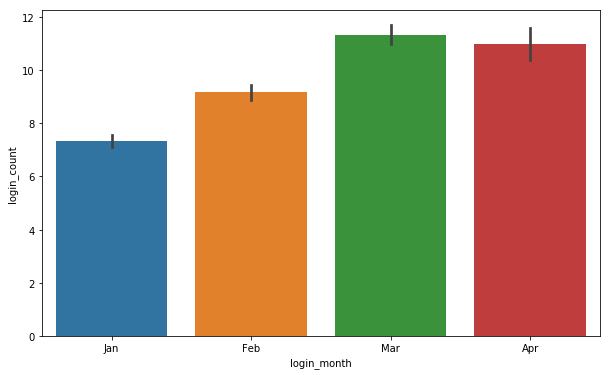

In [19]:
plt.rcParams["figure.figsize"] = (10,6)
sns.barplot(x="login_month", y="login_count", data=df_blocks, order=['Jan','Feb','Mar','Apr'])

### The breakdown for days of the month doesn't seem to reveal much.  I was hoping to see something near the first and fifteenth of the month (typical paydays), but there isn't an obvious trend.  

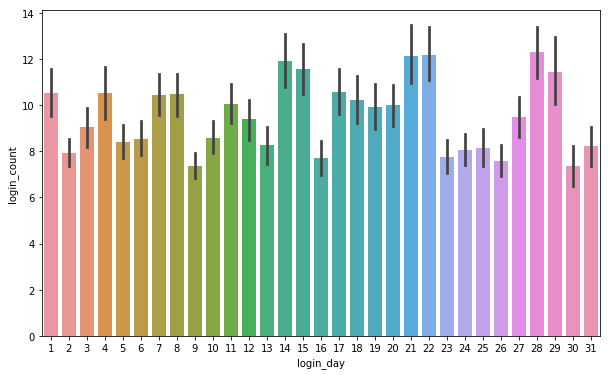

In [20]:
sns.barplot(x="login_day", y="login_count", data=df_blocks)

### There is clearly a trend for the days of the week.  Logins build over the week peaking on Saturday.  

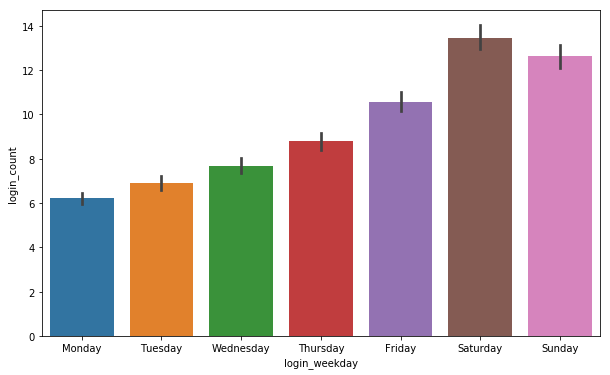

In [21]:
sns.barplot(x="login_weekday", y="login_count", data=df_blocks, order=['Monday','Tuesday','Wednesday',
                                                              'Thursday','Friday','Saturday','Sunday'])

### Another clear trend on the time of day that peole login.  Overnight and mid-day are popular.

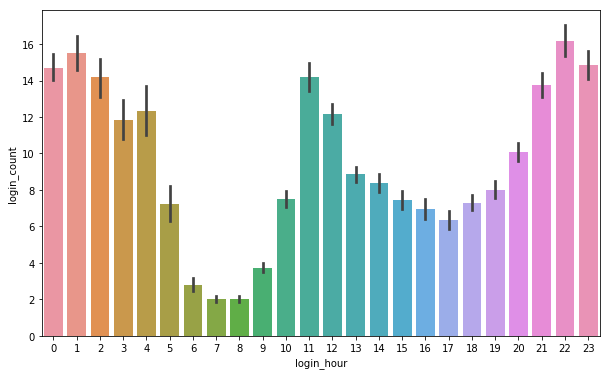

In [22]:
sns.barplot(x="login_hour", y="login_count", data=df_blocks)

### I have broken the logins for each hour of the day by day of week as well.  To make it easier to visualize I have also kept the axis the same size for all 7 graphs.  There is a distinct change in the weekends vs the weekdays.  

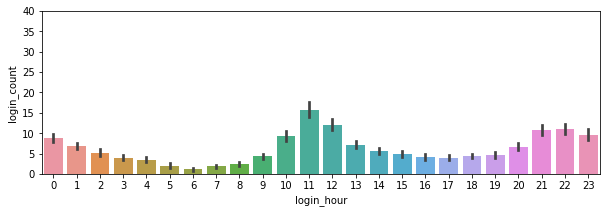

In [23]:
plt.rcParams["figure.figsize"] = (10,3) #set the figure size for all following figures
plt.ylim(0, 40) # set the y-limit for this figure
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Monday'])

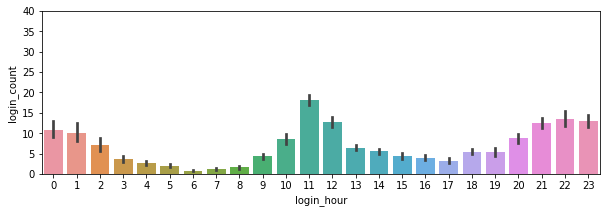

In [24]:
plt.ylim(0, 40)
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Tuesday'])

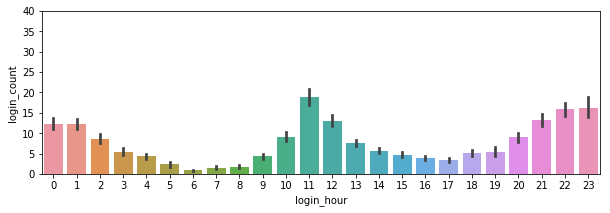

In [25]:
plt.ylim(0, 40)
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Wednesday'])

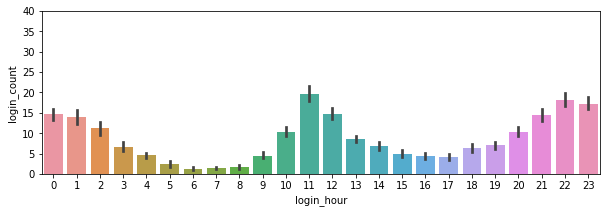

In [26]:
plt.ylim(0, 40)
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Thursday'])

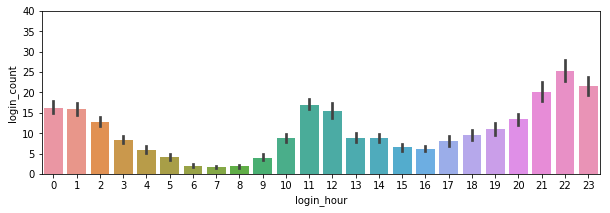

In [27]:
plt.ylim(0, 40)
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Friday'])

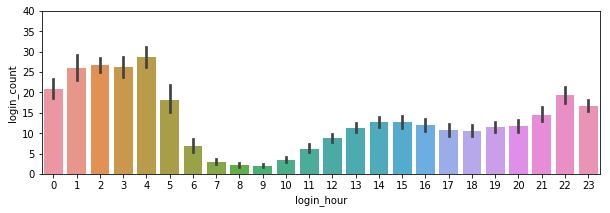

In [28]:
plt.ylim(0, 40)
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Saturday'])

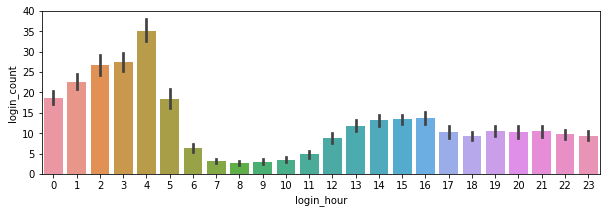

In [29]:
plt.ylim(0, 40)
sns.barplot(x="login_hour", y="login_count", data=df_blocks[df_blocks['login_weekday']=='Sunday'])